In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import time
from matplotlib.patches import Patch

In [2]:
def initialize_grid(grid_size=100, obstacle_ratio=0.3, distance_ratio=0.7):
    grid = np.zeros((grid_size, grid_size))
    move_directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    
    min_distance = int(grid_size * distance_ratio)
    
    zones = [
        (0, 0, grid_size//3, grid_size//3),              
        (grid_size*2//3, grid_size*2//3, grid_size-1, grid_size-1) 
    ]
    
    start_zone, end_zone = zones
    start = (random.randint(start_zone[0], start_zone[2]), random.randint(start_zone[1], start_zone[3]))
    end = (random.randint(end_zone[0], end_zone[2]), random.randint(end_zone[1], end_zone[3]))
    
    while manhattan_distance(start, end) < min_distance:
        end = (random.randint(end_zone[0], end_zone[2]), random.randint(end_zone[1], end_zone[3]))
    
    generate_obstacles(grid, grid_size, obstacle_ratio, start, end)
    grid[start] = 2
    grid[end] = 3
    
    print(f"Start position: {start}")
    print(f"Goal position: {end}")
    print(f"Manhattan distance: {manhattan_distance(start, end)}")
    
    return grid, start, end, move_directions

In [3]:
def manhattan_distance(point_a, point_b):
    return abs(point_a[0] - point_b[0]) + abs(point_a[1] - point_b[1])

In [4]:
def generate_obstacles(grid, grid_size, density, start, end):
    obstacle_count = int(grid_size * grid_size * density)
    obstacle_area = 3
    start_x, start_y = start
    end_x, end_y = end
    placed_obstacles = 0
    
    while placed_obstacles < obstacle_count:
        x, y = random.randint(0, grid_size-1), random.randint(0, grid_size-1)
        
        is_near_vertical_path = (min(start_x, end_x) - obstacle_area <= x <= max(start_x, end_x) + obstacle_area and abs(y - start_y) <= obstacle_area)
        is_near_horizontal_path = (min(start_y, end_y) - obstacle_area <= y <= max(start_y, end_y) + obstacle_area and abs(x - end_x) <= obstacle_area)
        
        if ((x, y) != start and (x, y) != end and not is_near_vertical_path and not is_near_horizontal_path and grid[x, y] == 0):
            grid[x, y] = 1
            placed_obstacles += 1

In [5]:
def valid_position(grid, grid_size, position):
    x, y = position
    return (0 <= x < grid_size and 0 <= y < grid_size and grid[x, y] != 1)

In [6]:
def move_position(grid, grid_size, position, direction, move_directions):
    new_x = position[0] + move_directions[direction][0]
    new_y = position[1] + move_directions[direction][1]
    return (new_x, new_y) if valid_position(grid, grid_size, (new_x, new_y)) else position

In [7]:
def calculate_reward(position, goal):
    return 100 if position == goal else -1

In [8]:
def check_goal(position, goal):
    return position == goal

In [9]:
def value_iteration(grid, grid_size, start, goal, move_directions, gamma=0.99, epsilon=1e-6, max_iters=1000):
    values = defaultdict(float)
    policy = {}
    steps = 0
    
    for i in range(max_iters):
        delta = 0
        for x in range(grid_size):
            for y in range(grid_size):
                if grid[x, y] == 1:
                    continue
                state = (x, y)
                if check_goal(state, goal):
                    continue
                    
                current_value = values[state]
                best_value = float('-inf')
                best_action = None
                
                for direction in range(len(move_directions)):
                    next_state = move_position(grid, grid_size, state, direction, move_directions)
                    reward = calculate_reward(next_state, goal)
                    value_next = reward + gamma * values[next_state]
                    
                    if value_next > best_value:
                        best_value = value_next
                        best_action = direction
                
                values[state] = best_value
                policy[state] = best_action
                delta = max(delta, abs(current_value - values[state]))
        
        steps = i + 1
        if delta < epsilon:
            break
    
    return values, policy, steps

In [10]:
def q_learning(grid, grid_size, start, goal, move_directions, learning_rate=0.1, gamma=0.99, exploration_rate=0.1, max_episodes=10000):
    q_values = defaultdict(lambda: defaultdict(float))
    policy = {}
    steps = 0
    stable_counter = 0
    stability_threshold = 50
    
    for episode in range(max_episodes):
        state = start
        while not check_goal(state, goal):
            action = get_exploratory_action(q_values, state, move_directions, exploration_rate)
            next_state = move_position(grid, grid_size, state, action, move_directions)
            reward = calculate_reward(next_state, goal)
            
            if q_values[next_state]:
                best_next_value = max(q_values[next_state].values())
            else:
                best_next_value = 0
            
            target_value = reward + gamma * best_next_value
            q_values[state][action] += learning_rate * (target_value - q_values[state][action])
            
            state = next_state
        
      
        current_policy = {state: max(actions, key=actions.get) for state, actions in q_values.items() if actions}

        if episode > 0 and current_policy == policy:
            stable_counter += 1
            if stable_counter >= stability_threshold:
                steps = episode + 1
                break
        else:
            stable_counter = 0
        
        policy = current_policy.copy()
    
    return q_values, policy, steps


In [11]:
def get_exploratory_action(q_values, state, move_directions, exploration_rate):
    if random.random() < exploration_rate:
        return random.randrange(len(move_directions))
    else:
        return max(q_values[state], key=q_values[state].get, default=random.randrange(len(move_directions)))

In [12]:
def find_path(grid, grid_size, start, goal, move_directions, policy):
    path = [start]
    state = start
    max_path_steps = grid_size ** 2
    
    for _ in range(max_path_steps):
        if state == goal:
            return path
        action = policy.get(state)
        if action is None:
            return None
        state = move_position(grid, grid_size, state, action, move_directions)
        path.append(state)
    
    return path if state == goal else None

In [13]:
def display_policy(grid, grid_size, move_directions, policy, path, title="Policy Visualization", steps=None):
    plt.figure(figsize=(12, 10))

    cmap = mcolors.ListedColormap(['white', 'black', 'lightgreen', 'yellow', 'lightblue'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(grid, cmap=cmap, norm=norm)
    
    for state, action in policy.items():
        if grid[state] not in [1, 3]: 
            dx, dy = move_directions[action]
            plt.arrow(state[1], state[0], dy*0.3, dx*0.3, head_width=0.25, head_length=0.25, fc='orange', ec='orange', alpha=0.7)

    if path:
        path_x = [p[0] for p in path]
        path_y = [p[1] for p in path]
        plt.plot(path_y, path_x, 'b-', linewidth=3, alpha=0.8, label=f'Path (Steps: {len(path) - 1})')
        for i in range(1, len(path)):
            dx = path[i][0] - path[i-1][0]
            dy = path[i][1] - path[i-1][1]
            plt.arrow(path[i-1][1], path[i-1][0], dy*0.3, dx*0.3, head_width=0.15, head_length=0.15, fc='blue', ec='blue', alpha=0.9)

    start_x, start_y = path[0]
    goal_x, goal_y = path[-1]
    plt.scatter([start_y], [start_x], color='green', s=100, label='Start', edgecolor='black', zorder=5)
    plt.scatter([goal_y], [goal_x], color='yellow', s=100, label='Goal', edgecolor='black', zorder=5)

    plt.title(f"{title}\nConvergence Steps: {steps}" if steps else title, fontsize=16, fontweight='bold')
    legend_elements = [
        Patch(facecolor='white', edgecolor='black', label='Empty'),
        Patch(facecolor='black', edgecolor='black', label='Obstacle'),
        Patch(facecolor='lightgreen', edgecolor='black', label='Start'),
        Patch(facecolor='yellow', edgecolor='black', label='Goal'),
        Patch(facecolor='orange', edgecolor='orange', label='Policy Direction'),
        Patch(facecolor='lightblue', edgecolor='blue', label='Path')
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

In [14]:
grid, start, goal, move_directions = initialize_grid(grid_size=100, obstacle_ratio=0.3)
v_values, v_policy, v_steps = value_iteration(grid, 100, start, goal, move_directions)
q_values, q_policy, q_steps = q_learning(grid, 100, start, goal, move_directions)

Start position: (12, 3)
Goal position: (80, 84)
Manhattan distance: 149


In [15]:
import seaborn as sns
import matplotlib.colors as mcolors

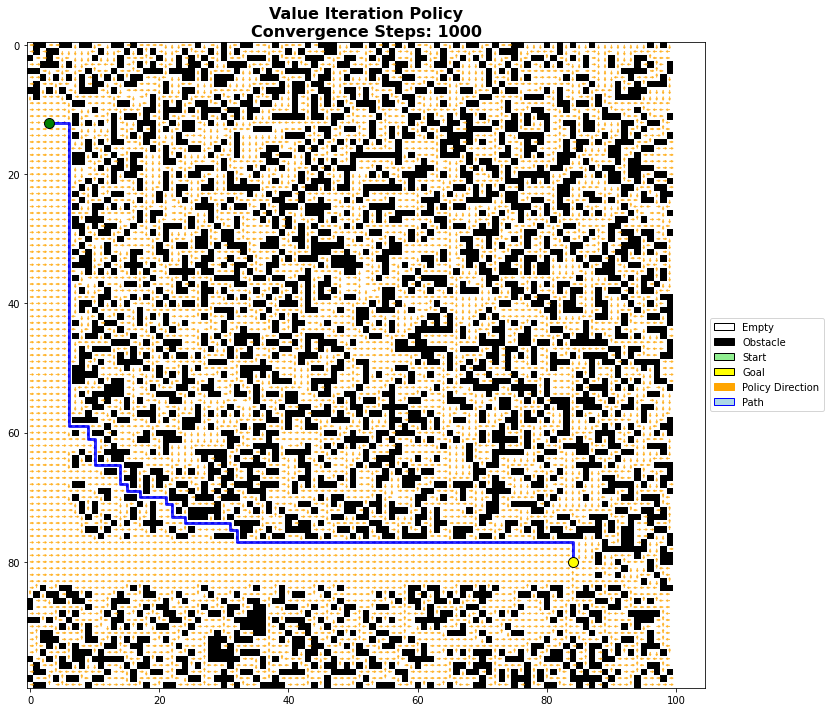

In [16]:
display_policy(grid, 100, move_directions, v_policy, find_path(grid, 100, start, goal, move_directions, v_policy), "Value Iteration Policy", v_steps)

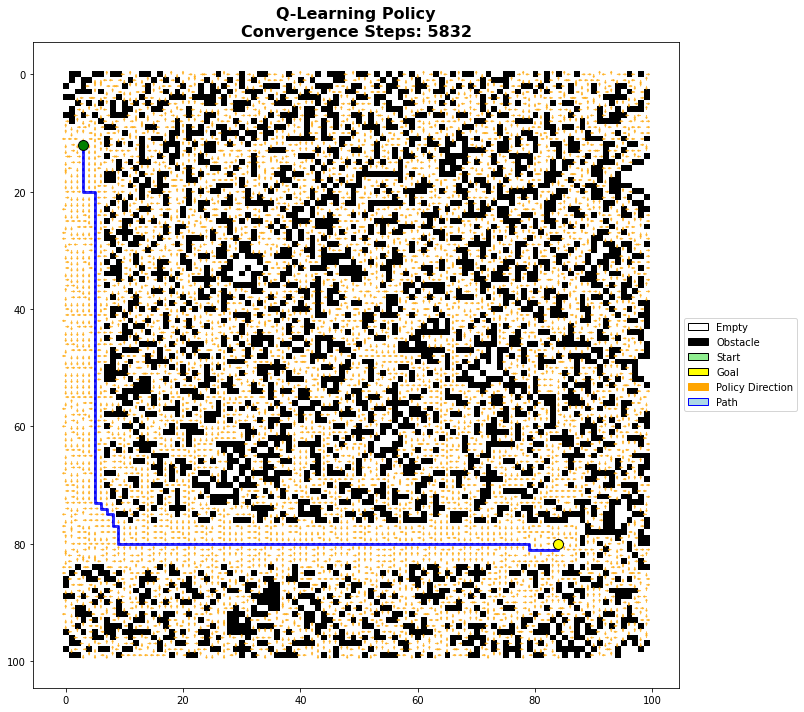

In [17]:
display_policy(grid, 100, move_directions, q_policy, find_path(grid, 100, start, goal, move_directions, q_policy), "Q-Learning Policy", q_steps)